# Setup

In [1]:
library(keras)
library(tensorflow)
tf$test$gpu_device_name()

Loaded Tensorflow version 2.9.3



[1] ""

In [5]:
options(repr.matrix.max.rows=100, repr.matrix.max.cols=300)
options(
    repr.plot.res = 120,
    repr.plot.width = 10,
    repr.plot.height = 7, 
    repr.plot.pointsize = 12, 
    repr.plot.quality = 100
)
options(width=300)
    
numcores=56

library(tidyverse)
library(parallel)
library(data.table)
library(fst)
library(comorbidity)
library(zeallot)
library(reshape)
library(dtplyr)
library(vroom)
library(dplyr)

#library(icd)
`%!in%` = Negate(`%in%`)

setDTthreads(numcores)

   
    setosa versicolor virginica
  1     50          0         0
  2      0          2        36
  3      0         48        14

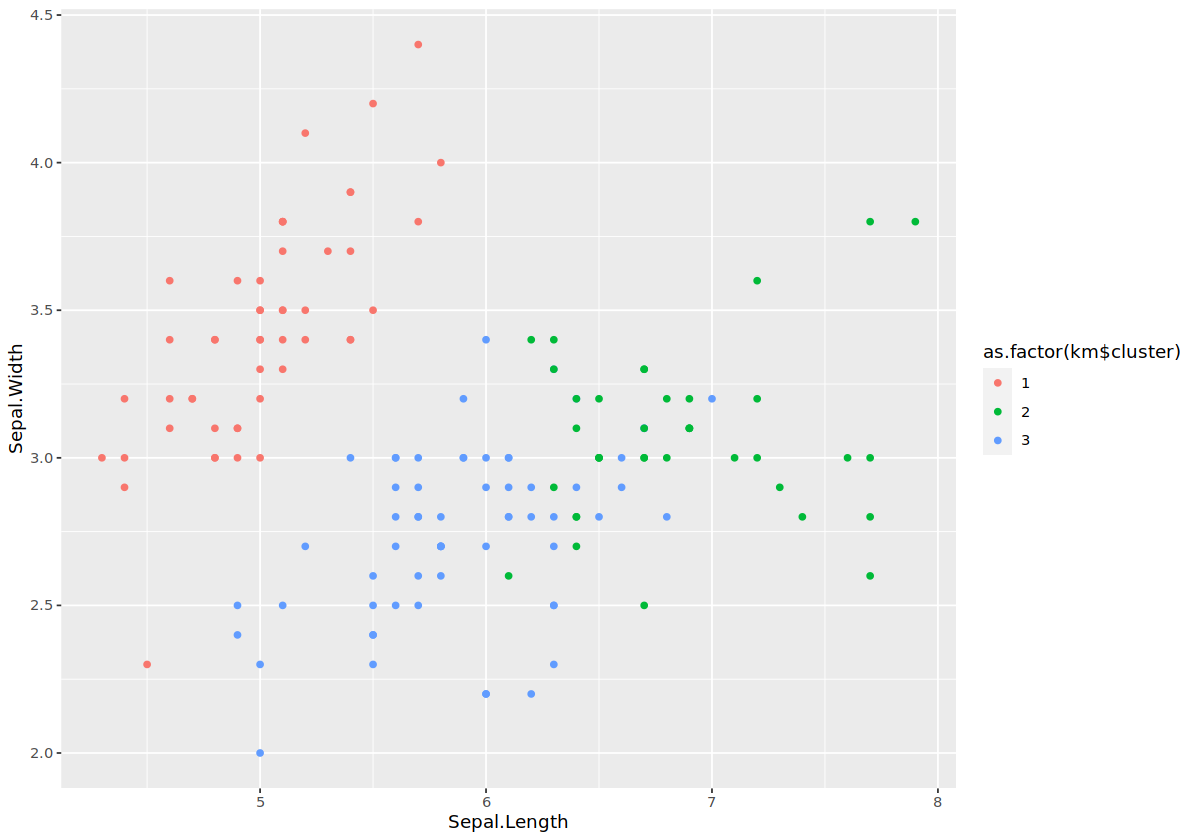

In [3]:
km <- kmeans(iris[, 1:4], 3)
ggplot(iris, aes(x = Sepal.Length, y = Sepal.Width, color = as.factor(km$cluster))) +
  geom_point()
table(km$cluster, iris$Species)

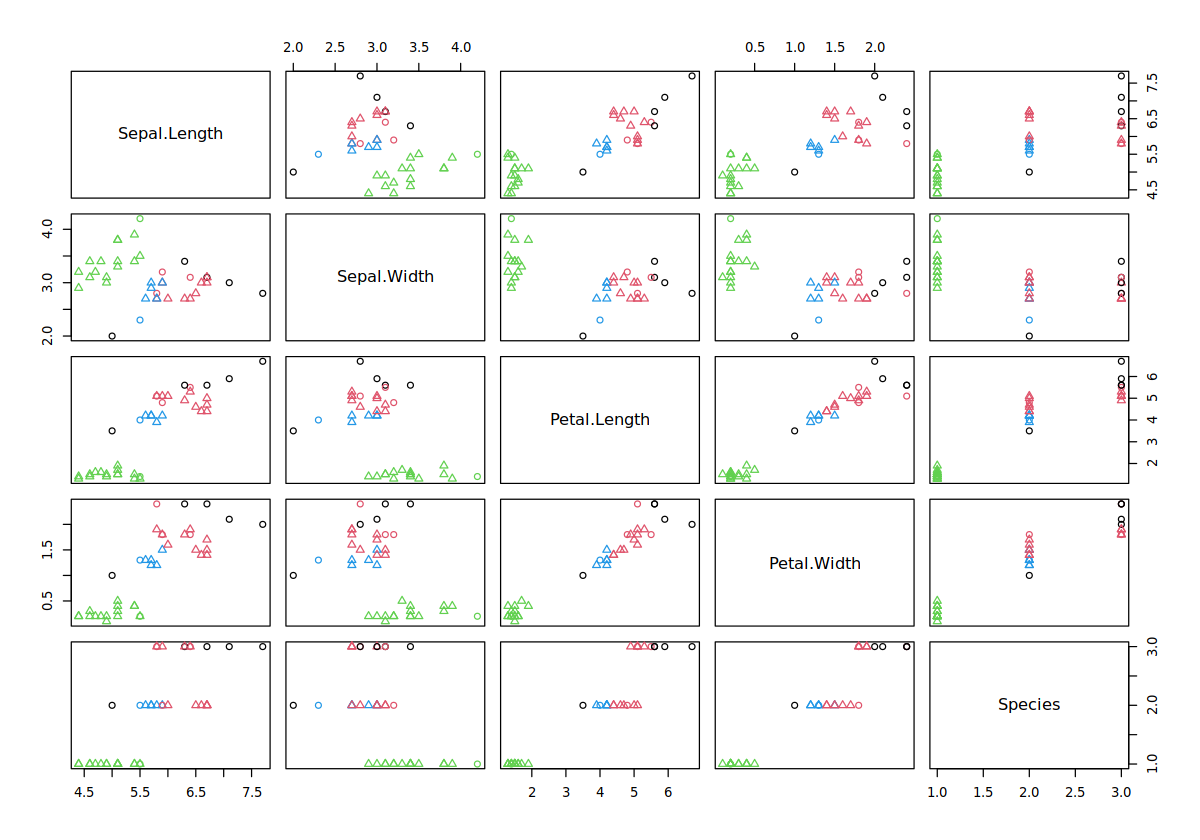

   
    setosa versicolor virginica
  0      0          1         4
  1      0          7         6
  2     16          0         0
  3      0          6         0

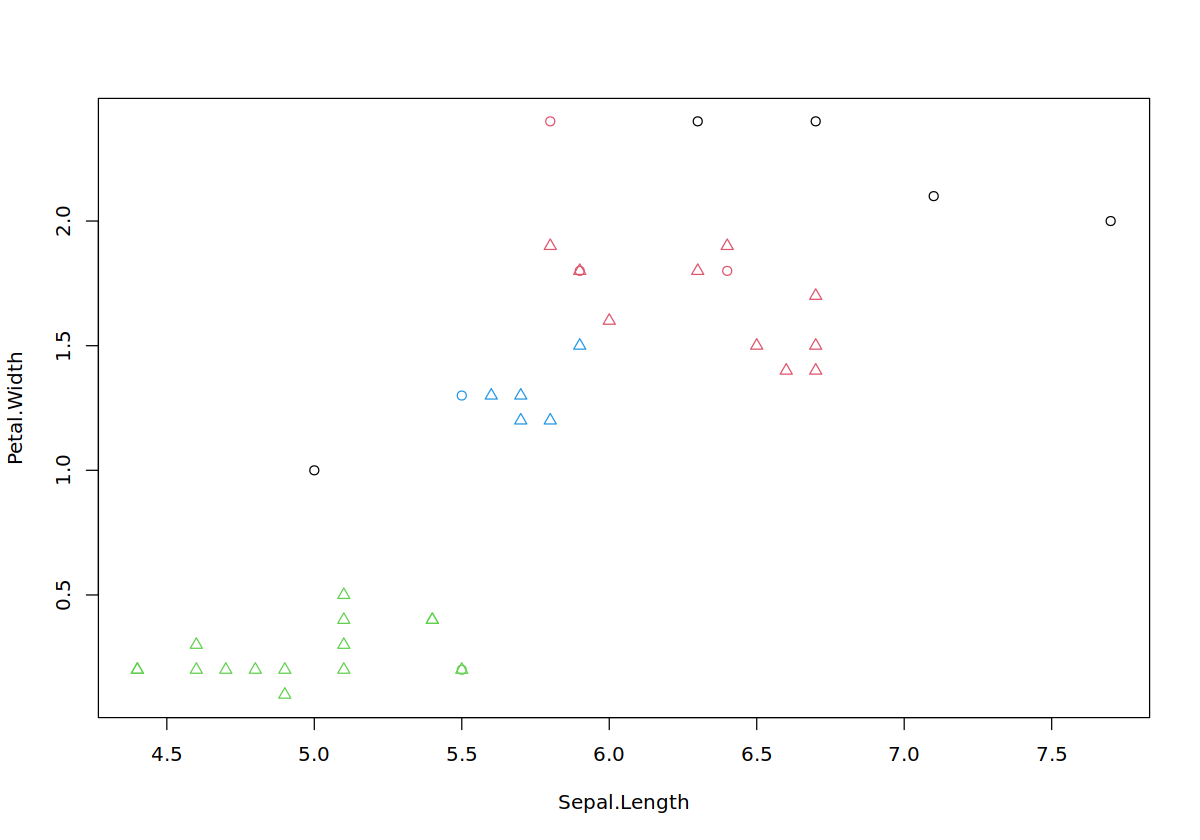

In [4]:
sampleiris <- iris[sample(1:150, 40), ] # get samples from iris dataset
library(fpc)
# eps is radius of neighborhood, MinPts is no of neighbors
# within eps
cluster <- dbscan(sampleiris[, -5], eps = 0.6, MinPts = 4)
plot(cluster, sampleiris)
plot(cluster, sampleiris[, c(1, 4)])
# Notice points in cluster 0 are unassigned outliers
table(cluster$cluster, sampleiris$Species)

In [16]:
model <- ... # create the original model
layer_name <- "my_layer"
intermediate_layer_model <- keras_model(
    inputs = model$input,
    outputs = get_layer(model, layer_name)$output
)
intermediate_output <- predict(intermediate_layer_model, data)

ERROR: Error in eval(expr, envir, enclos): '...' used in an incorrect context


# Extracting the needed data from the datasets
Here, we will create a data.table with the following columns:
* id: the unique identifier of each Medicare beneficiary
* year: the year of the Medicare claim
* diagnosis: the diagnosis code of the claim
* procedure: the procedure code of the claim
* provider: the provider of the claim
* provider_specialty: the specialty of the provider
* cost: the cost of the claim

We will only use 2016 to 2019 data for this analysis.
We exclude 2020 due to the COVID-19 pandemic. We exclude 2013-2015 due to use of the ICD-9 coding system.

## Carrier files

In [4]:
carrier_data_2016 = read_fst("/work/postresearch/Shared/Projects/Data_fst/carrier_data_2016.fst",
    as.data.table = T,
    columns = c("DESY_SORT_KEY", "LINE_ICD_DGNS_CD", "PRF_PHYSN_NPI", "PRVDR_SPCLTY", "HCPCS_CD", "CLM_THRU_DT", "LINE_ALOWD_CHRG_AMT")
)
carrier_data_2017 = read_fst("/work/postresearch/Shared/Projects/Data_fst/carrier_data_2017.fst",
    as.data.table = T,
    columns = c("DESY_SORT_KEY", "LINE_ICD_DGNS_CD", "PRF_PHYSN_NPI", "PRVDR_SPCLTY", "HCPCS_CD", "CLM_THRU_DT", "LINE_ALOWD_CHRG_AMT")
)
carrier_data_2018 = read_fst("/work/postresearch/Shared/Projects/Data_fst/carrier_data_2018.fst",
    as.data.table = T,
    columns = c("DESY_SORT_KEY", "LINE_ICD_DGNS_CD", "PRF_PHYSN_NPI", "PRVDR_SPCLTY", "HCPCS_CD", "CLM_THRU_DT", "LINE_ALOWD_CHRG_AMT")
)
carrier_data_2019 = read_fst("/work/postresearch/Shared/Projects/Data_fst/carrier_data_2019.fst",
    as.data.table = T,
    columns = c("DESY_SORT_KEY", "LINE_ICD_DGNS_CD", "PRF_PHYSN_NPI", "PRVDR_SPCLTY", "HCPCS_CD", "CLM_THRU_DT", "LINE_ALOWD_CHRG_AMT")
)

In [5]:
# change the column names
setnames(
    carrier_data_2016,
    c("id", "diagnosis", "provider", "provider_specialty", "hcpcs", "date", "cost")
)

setnames(
    carrier_data_2017,
    c("id", "diagnosis", "provider", "provider_specialty", "hcpcs", "date", "cost")
)

setnames(
    carrier_data_2018,
    c("id", "diagnosis", "provider", "provider_specialty", "hcpcs", "date", "cost")
)

setnames(
    carrier_data_2019,
    c("id", "diagnosis", "provider", "provider_specialty", "hcpcs", "date", "cost")
)

In [8]:
# add the year to the data
carrier_data_2016[, year := 2016]
carrier_data_2017[, year := 2017]
carrier_data_2018[, year := 2018]
carrier_data_2019[, year := 2019]

# combine the data

carrier_data = rbindlist(
    list(
        carrier_data_2016,
        carrier_data_2017,
        carrier_data_2018,
        carrier_data_2019
    ),
    use.names = T
)

In [11]:
head(carrier_data)

id,diagnosis,provider,provider_specialty,hcpcs,date,cost,year
<int>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>
100000015,H3532,1265609275,18,67028,20160129,110.66,2016
100000015,H3532,1265609275,18,J0178,20160129,1961.00,2016
100000015,I10,1730170630,06,99214,20160212,113.64,2016
100000015,I10,1730170630,06,93000,20160212,18.34,2016
100000015,I479,1730170630,06,93457,20160218,371.86,2016
100000015,I252,1730170630,06,99217,20160219,75.37,2016


In [10]:
# Save the combined data as fst to folder with no compression
write_fst(carrier_data, "/work/postresearch/Shared/Projects/Farbod/Clustering/carrier_data.fst", compress = 0)

## Inpatient files

In [12]:
inpatient_data_2016 = read_fst("/work/postresearch/Shared/Projects/Data_fst/inpatient_data_2016.fst", as.data.table = T)
inpatient_data_2017 = read_fst("/work/postresearch/Shared/Projects/Data_fst/inpatient_data_2017.fst",as.data.table = T)
inpatient_data_2018 = read_fst("/work/postresearch/Shared/Projects/Data_fst/inpatient_data_2018.fst", as.data.table = T)
inpatient_data_2019 = read_fst("/work/postresearch/Shared/Projects/Data_fst/inpatient_data_2019.fst",as.data.table = T)

In [13]:
# add the year to the data

inpatient_data_2016[, year := 2016]
inpatient_data_2017[, year := 2017]
inpatient_data_2018[, year := 2018]
inpatient_data_2019[, year := 2019]


#combine the data
inpatient_data = rbindlist(
    list(
        inpatient_data_2016,
        inpatient_data_2017,
        inpatient_data_2018,
        inpatient_data_2019
    ),
    use.names = T
)


In [15]:
# Save the combined data as fst to folder with no compression
write_fst(inpatient_data, "/work/postresearch/Shared/Projects/Farbod/Clustering/inpatient_data.fst", compress = 0)

## Outpatient files

In [16]:
outpatient_data_2016 = read_fst("/work/postresearch/Shared/Projects/Data_fst/outpatient_data_2016.fst",as.data.table = T)
outpatient_data_2017 = read_fst("/work/postresearch/Shared/Projects/Data_fst/outpatient_data_2017.fst",as.data.table = T)
outpatient_data_2018 = read_fst("/work/postresearch/Shared/Projects/Data_fst/outpatient_data_2018.fst",as.data.table = T)
outpatient_data_2019 = read_fst("/work/postresearch/Shared/Projects/Data_fst/outpatient_data_2019.fst",as.data.table = T)

In [18]:
# add the year to the data

outpatient_data_2016[, year := 2016]
outpatient_data_2017[, year := 2017]
outpatient_data_2018[, year := 2018]
outpatient_data_2019[, year := 2019]


# combine the data
outpatient_data = rbindlist(
    list(
        outpatient_data_2016,
        outpatient_data_2017,
        outpatient_data_2018,
        outpatient_data_2019
    ),
    use.names = T
)

In [19]:
# Save the combined data as fst to folder with no compression
write_fst(outpatient_data, "/work/postresearch/Shared/Projects/Farbod/Clustering/outpatient_data.fst", compress = 0)

## Create a small sample for local analyses

In [8]:
# create a sample of 10000 patients based on id
sample_id = sample(carrier_data$id, 10000)

# sample the data based on the ids sampled
carrier_data_sample = carrier_data[id %in% sample_id]
inpatient_data_sample = inpatient_data[DESY_SORT_KEY %in% sample_id]
outpatient_data_sample = outpatient_data[DESY_SORT_KEY %in% sample_id]


In [9]:
head(carrier_data_sample)
head(inpatient_data_sample)
head(outpatient_data_sample)


id,diagnosis,provider,provider_specialty,hcpcs,date,cost,year
<int>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>
100009375,H2703,1245214063,18,92014,20160118,117.32,2016
100009375,K635,1215931563,10,99215,20160307,138.05,2016
100009375,K635,1215931563,10,1036F,20160307,0.00,2016
100009375,K635,1215931563,10,G8420,20160307,0.00,2016
100009375,K635,1215931563,10,G8752,20160307,0.00,2016
100009375,K635,1215931563,10,G8754,20160307,0.00,2016


DESY_SORT_KEY,CLAIM_NO,PRVDR_NUM,CLM_THRU_DT,NCH_NEAR_LINE_REC_IDENT_CD,NCH_CLM_TYPE_CD,CLAIM_QUERY_CODE,CLM_FAC_TYPE_CD,CLM_SRVC_CLSFCTN_TYPE_CD,CLM_FREQ_CD,FI_NUM,CLM_MDCR_NON_PMT_RSN_CD,CLM_PMT_AMT,NCH_PRMRY_PYR_CLM_PD_AMT,NCH_PRMRY_PYR_CD,FI_CLM_ACTN_CD,PRVDR_STATE_CD,ORG_NPI_NUM,AT_PHYSN_UPIN,AT_PHYSN_NPI,AT_PHYSN_SPCLTY_CD,OP_PHYSN_UPIN,OP_PHYSN_NPI,OP_PHYSN_SPCLTY_CD,OT_PHYSN_UPIN,OT_PHYSN_NPI,OT_PHYSN_SPCLTY_CD,RNDRNG_PHYSN_NPI,RNDRNG_PHYSN_SPCLTY_CD,CLM_MCO_PD_SW,PTNT_DSCHRG_STUS_CD,CLM_PPS_IND_CD,CLM_TOT_CHRG_AMT,CLM_ADMSN_DT,CLM_IP_ADMSN_TYPE_CD,CLM_SRC_IP_ADMSN_CD,NCH_PTNT_STATUS_IND_CD,CLM_PASS_THRU_PER_DIEM_AMT,NCH_BENE_IP_DDCTBL_AMT,NCH_BENE_PTA_COINSRNC_LBLTY_AM,NCH_BENE_BLOOD_DDCTBL_LBLTY_AM,NCH_PROFNL_CMPNT_CHRG_AMT,NCH_IP_NCVRD_CHRG_AMT,CLM_TOT_PPS_CPTL_AMT,CLM_PPS_CPTL_FSP_AMT,CLM_PPS_CPTL_OUTLIER_AMT,CLM_PPS_CPTL_DSPRPRTNT_SHR_AMT,CLM_PPS_CPTL_IME_AMT,CLM_PPS_CPTL_EXCPTN_AMT,CLM_PPS_OLD_CPTL_HLD_HRMLS_AMT,CLM_PPS_CPTL_DRG_WT_NUM,CLM_UTLZTN_DAY_CNT,BENE_TOT_COINSRNC_DAYS_CNT,BENE_LRD_USED_CNT,CLM_NON_UTLZTN_DAYS_CNT,NCH_BLOOD_PNTS_FRNSHD_QTY,NCH_VRFD_NCVRD_STAY_FROM_DT,NCH_VRFD_NCVRD_STAY_THRU_DT,NCH_BENE_MDCR_BNFTS_EXHTD_DT_I,NCH_BENE_DSCHRG_DT,CLM_DRG_CD,CLM_DRG_OUTLIER_STAY_CD,NCH_DRG_OUTLIER_APRVD_PMT_AMT,ADMTG_DGNS_CD,PRNCPAL_DGNS_CD,ICD_DGNS_CD1,CLM_POA_IND_SW1,ICD_DGNS_CD2,CLM_POA_IND_SW2,ICD_DGNS_CD3,CLM_POA_IND_SW3,ICD_DGNS_CD4,CLM_POA_IND_SW4,ICD_DGNS_CD5,CLM_POA_IND_SW5,ICD_DGNS_CD6,CLM_POA_IND_SW6,ICD_DGNS_CD7,CLM_POA_IND_SW7,ICD_DGNS_CD8,CLM_POA_IND_SW8,ICD_DGNS_CD9,CLM_POA_IND_SW9,ICD_DGNS_CD10,CLM_POA_IND_SW10,ICD_DGNS_CD11,CLM_POA_IND_SW11,ICD_DGNS_CD12,CLM_POA_IND_SW12,ICD_DGNS_CD13,CLM_POA_IND_SW13,ICD_DGNS_CD14,CLM_POA_IND_SW14,ICD_DGNS_CD15,CLM_POA_IND_SW15,ICD_DGNS_CD16,CLM_POA_IND_SW16,ICD_DGNS_CD17,CLM_POA_IND_SW17,ICD_DGNS_CD18,CLM_POA_IND_SW18,ICD_DGNS_CD19,CLM_POA_IND_SW19,ICD_DGNS_CD20,CLM_POA_IND_SW20,ICD_DGNS_CD21,CLM_POA_IND_SW21,ICD_DGNS_CD22,CLM_POA_IND_SW22,ICD_DGNS_CD23,CLM_POA_IND_SW23,ICD_DGNS_CD24,CLM_POA_IND_SW24,ICD_DGNS_CD25,CLM_POA_IND_SW25,FST_DGNS_E_CD,ICD_DGNS_E_CD1,CLM_E_POA_IND_SW1,ICD_DGNS_E_CD2,CLM_E_POA_IND_SW2,ICD_DGNS_E_CD3,CLM_E_POA_IND_SW3,ICD_DGNS_E_CD4,CLM_E_POA_IND_SW4,ICD_DGNS_E_CD5,CLM_E_POA_IND_SW5,ICD_DGNS_E_CD6,CLM_E_POA_IND_SW6,ICD_DGNS_E_CD7,CLM_E_POA_IND_SW7,ICD_DGNS_E_CD8,CLM_E_POA_IND_SW8,ICD_DGNS_E_CD9,CLM_E_POA_IND_SW9,ICD_DGNS_E_CD10,CLM_E_POA_IND_SW10,ICD_DGNS_E_CD11,CLM_E_POA_IND_SW11,ICD_DGNS_E_CD12,CLM_E_POA_IND_SW12,ICD_PRCDR_CD1,PRCDR_DT1,ICD_PRCDR_CD2,PRCDR_DT2,ICD_PRCDR_CD3,PRCDR_DT3,ICD_PRCDR_CD4,PRCDR_DT4,ICD_PRCDR_CD5,PRCDR_DT5,ICD_PRCDR_CD6,PRCDR_DT6,ICD_PRCDR_CD7,PRCDR_DT7,ICD_PRCDR_CD8,PRCDR_DT8,ICD_PRCDR_CD9,PRCDR_DT9,ICD_PRCDR_CD10,PRCDR_DT10,ICD_PRCDR_CD11,PRCDR_DT11,ICD_PRCDR_CD12,PRCDR_DT12,ICD_PRCDR_CD13,PRCDR_DT13,ICD_PRCDR_CD14,PRCDR_DT14,ICD_PRCDR_CD15,PRCDR_DT15,ICD_PRCDR_CD16,PRCDR_DT16,ICD_PRCDR_CD17,PRCDR_DT17,ICD_PRCDR_CD18,PRCDR_DT18,ICD_PRCDR_CD19,PRCDR_DT19,ICD_PRCDR_CD20,PRCDR_DT20,ICD_PRCDR_CD21,PRCDR_DT21,ICD_PRCDR_CD22,PRCDR_DT22,ICD_PRCDR_CD23,PRCDR_DT23,ICD_PRCDR_CD24,PRCDR_DT24,ICD_PRCDR_CD25,PRCDR_DT25,DOB_DT,GNDR_CD,BENE_RACE_CD,BENE_CNTY_CD,BENE_STATE_CD,CWF_BENE_MDCR_STUS_CD,CLM_TRTMT_AUTHRZTN_NUM,CLM_PRCR_RTRN_CD,CLM_IP_LOW_VOL_PMT_AMT,CLM_CARE_IMPRVMT_MODEL_CD1,CLM_CARE_IMPRVMT_MODEL_CD2,CLM_CARE_IMPRVMT_MODEL_CD3,CLM_CARE_IMPRVMT_MODEL_CD4,CLM_BNDLD_MODEL_1_DSCNT_PCT,CLM_BASE_OPRTG_DRG_AMT,CLM_VBP_PRTCPNT_IND_CD,CLM_VBP_ADJSTMT_PCT,CLM_HRR_PRTCPNT_IND_CD,CLM_HRR_ADJSTMT_PCT,CLM_MODEL_4_READMSN_IND_CD,CLM_UNCOMPD_CARE_PMT_AMT,CLM_BNDLD_ADJSTMT_PMT_AMT,CLM_VBP_ADJSTMT_PMT_AMT,CLM_HRR_ADJSTMT_PMT_AMT,EHR_PYMT_ADJSTMT_AMT,PPS_STD_VAL_PYMT_AMT,FINL_STD_AMT,HAC_PGM_RDCTN_IND_SW,EHR_PGM_RDCTN_IND_SW,CLM_SITE_NTRL_PYMT_CST_AMT,CLM_SITE_NTRL_PYMT_IPPS_AMT,CLM_FULL_STD_PYMT_AMT,CLM_SS_OUTLIER_STD_PYMT_AMT,CLM_NEXT_GNRTN_ACO_IND_CD1,CLM_NEXT_GNRTN_ACO_IND_CD2,CLM_NEXT_GNRTN_ACO_IND_CD3,CLM_NEXT_GNRTN_ACO_IND_CD4,CLM_NEXT_GNRTN_ACO_IND_CD5,ACO_ID_NUM,year
<int>,<int>,<chr>,<int>,<chr>,<int>,<int>,<int>,<int

DESY_SORT_KEY,CLAIM_NO,PRVDR_NUM,CLM_THRU_DT,NCH_NEAR_LINE_REC_IDENT_CD,NCH_CLM_TYPE_CD,CLAIM_QUERY_CODE,CLM_FAC_TYPE_CD,CLM_SRVC_CLSFCTN_TYPE_CD,CLM_FREQ_CD,FI_NUM,CLM_MDCR_NON_PMT_RSN_CD,CLM_PMT_AMT,NCH_PRMRY_PYR_CLM_PD_AMT,NCH_PRMRY_PYR_CD,PRVDR_STATE_CD,ORG_NPI_NUM,SRVC_LOC_NPI_NUM,AT_PHYSN_UPIN,AT_PHYSN_NPI,AT_PHYSN_SPCLTY_CD,OP_PHYSN_UPIN,OP_PHYSN_NPI,OP_PHYSN_SPCLTY_CD,OT_PHYSN_UPIN,OT_PHYSN_NPI,OT_PHYSN_SPCLTY_CD,RNDRNG_PHYSN_NPI,RNDRNG_PHYSN_SPCLTY_CD,RFR_PHYSN_NPI,RFR_PHYSN_SPCLTY_CD,CLM_MCO_PD_SW,PTNT_DSCHRG_STUS_CD,CLM_TOT_CHRG_AMT,NCH_BENE_BLOOD_DDCTBL_LBLTY_AM,NCH_PROFNL_CMPNT_CHRG_AMT,PRNCPAL_DGNS_CD,ICD_DGNS_CD1,ICD_DGNS_CD2,ICD_DGNS_CD3,ICD_DGNS_CD4,ICD_DGNS_CD5,ICD_DGNS_CD6,ICD_DGNS_CD7,ICD_DGNS_CD8,ICD_DGNS_CD9,ICD_DGNS_CD10,ICD_DGNS_CD11,ICD_DGNS_CD12,ICD_DGNS_CD13,ICD_DGNS_CD14,ICD_DGNS_CD15,ICD_DGNS_CD16,ICD_DGNS_CD17,ICD_DGNS_CD18,ICD_DGNS_CD19,ICD_DGNS_CD20,ICD_DGNS_CD21,ICD_DGNS_CD22,ICD_DGNS_CD23,ICD_DGNS_CD24,ICD_DGNS_CD25,FST_DGNS_E_CD,ICD_DGNS_E_CD1,ICD_DGNS_E_CD2,ICD_DGNS_E_CD3,ICD_DGNS_E_CD4,ICD_DGNS_E_CD5,ICD_DGNS_E_CD6,ICD_DGNS_E_CD7,ICD_DGNS_E_CD8,ICD_DGNS_E_CD9,ICD_DGNS_E_CD10,ICD_DGNS_E_CD11,ICD_DGNS_E_CD12,ICD_PRCDR_CD1,PRCDR_DT1,ICD_PRCDR_CD2,PRCDR_DT2,ICD_PRCDR_CD3,PRCDR_DT3,ICD_PRCDR_CD4,PRCDR_DT4,ICD_PRCDR_CD5,PRCDR_DT5,ICD_PRCDR_CD6,PRCDR_DT6,ICD_PRCDR_CD7,PRCDR_DT7,ICD_PRCDR_CD8,PRCDR_DT8,ICD_PRCDR_CD9,PRCDR_DT9,ICD_PRCDR_CD10,PRCDR_DT10,ICD_PRCDR_CD11,PRCDR_DT11,ICD_PRCDR_CD12,PRCDR_DT12,ICD_PRCDR_CD13,PRCDR_DT13,ICD_PRCDR_CD14,PRCDR_DT14,ICD_PRCDR_CD15,PRCDR_DT15,ICD_PRCDR_CD16,PRCDR_DT16,ICD_PRCDR_CD17,PRCDR_DT17,ICD_PRCDR_CD18,PRCDR_DT18,ICD_PRCDR_CD19,PRCDR_DT19,ICD_PRCDR_CD20,PRCDR_DT20,ICD_PRCDR_CD21,PRCDR_DT21,ICD_PRCDR_CD22,PRCDR_DT22,ICD_PRCDR_CD23,PRCDR_DT23,ICD_PRCDR_CD24,PRCDR_DT24,ICD_PRCDR_CD25,PRCDR_DT25,RSN_VISIT_CD1,RSN_VISIT_CD2,RSN_VISIT_CD3,NCH_BENE_PTB_DDCTBL_AMT,NCH_BENE_PTB_COINSRNC_AMT,CLM_OP_PRVDR_PMT_AMT,CLM_OP_BENE_PMT_AMT,DOB_DT,GNDR_CD,BENE_RACE_CD,BENE_CNTY_CD,BENE_STATE_CD,CWF_BENE_MDCR_STUS_CD,FI_CLM_ACTN_CD,NCH_BLOOD_PNTS_FRNSHD_QTY,CLM_TRTMT_AUTHRZTN_NUM,CLM_PRCR_RTRN_CD,CLM_OP_TRANS_TYPE_CD,CLM_OP_ESRD_MTHD_CD,CLM_NEXT_GNRTN_ACO_IND_CD1,CLM_NEXT_GNRTN_ACO_IND_CD2,CLM_NEXT_GNRTN_ACO_IND_CD3,CLM_NEXT_GNRTN_ACO_IND_CD4,CLM_NEXT_GNRTN_ACO_IND_CD5,ACO_ID_NUM,year
<int>,<int>,<chr>,<int>,<chr>,<int>,<int>,<int>,<int>,<chr>,<int>,<chr>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<int>,<chr>,<int>,<chr>,<lgl>,<int>,<chr>,<lgl>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<int>,<chr>,<int>,<int>,<int>,<lgl>,<lgl>,<lgl>,<chr>,<dbl>
100009375,934,330222,20160311,W,40,3,1,4,1,13201,,33.22,0,,33,1073569331,NA,,1215931563,10,NA,NA,,NA,NA,,NA,,NA,,NA,1,678,0,NA,Z1211,Z1211,Z86010,K648,K635,,,,,,,,,,,,,,,,,,,,,,,,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,Z1211,Z86010,K648,0.00,8.48,33.22,0,4,1,1,640,33,10,1,0,,1,J,0,NA,NA,NA,NA,NA,,2016
100009375,935,330222,20160620,W,40,5,1,3,I,13201,,27.50,0,,33,1073569331,NA,,1154300762,92,NA,NA,,NA,NA,,NA,,NA,,NA,1,277,0,NA,C61,C61,,,,,,,,,,,,,,,,,,,,,,,,,,,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,C61,,,0.00,0.00,27.50,0,5,1,1,640,33,10,5,0,,1,C,0,NA,NA,NA,NA,NA,,2016
100009375,936,330222,20160624,W,40,3,1,3,1,13201,,71.05,

In [11]:
length(unique(carrier_data_sample$id))
length(unique(inpatient_data_sample$DESY_SORT_KEY))
length(unique(outpatient_data_sample$DESY_SORT_KEY))

[1] 9957

[1] 5807

[1] 9448

In [12]:
# save the sample to fst
write_fst(carrier_data_sample, "/work/postresearch/Shared/Projects/Farbod/Clustering/carrier_data_sample.fst")
write_fst(inpatient_data_sample, "/work/postresearch/Shared/Projects/Farbod/Clustering/inpatient_data_sample.fst")
write_fst(outpatient_data_sample, "/work/postresearch/Shared/Projects/Farbod/Clustering/outpatient_data_sample.fst")

## Extract the diagnoses and procedures from the files

We will also turn all the data into wide format.

In [13]:
# read the data
carrier_data <- read_fst("/work/postresearch/Shared/Projects/Farbod/Clustering/carrier_data_sample.fst", as.data.table = TRUE)
inpatient_data <- read_fst("/work/postresearch/Shared/Projects/Farbod/Clustering/inpatient_data_sample.fst", as.data.table = TRUE)
outpatient_data <- read_fst("/work/postresearch/Shared/Projects/Farbod/Clustering/outpatient_data_sample.fst", as.data.table = TRUE)

In [14]:
head(carrier_data)
head(inpatient_data)
head(outpatient_data)

id,diagnosis,provider,provider_specialty,hcpcs,date,cost,year
<int>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>
100009375,H2703,1245214063,18,92014,20160118,117.32,2016
100009375,K635,1215931563,10,99215,20160307,138.05,2016
100009375,K635,1215931563,10,1036F,20160307,0.00,2016
100009375,K635,1215931563,10,G8420,20160307,0.00,2016
100009375,K635,1215931563,10,G8752,20160307,0.00,2016
100009375,K635,1215931563,10,G8754,20160307,0.00,2016


DESY_SORT_KEY,CLAIM_NO,PRVDR_NUM,CLM_THRU_DT,NCH_NEAR_LINE_REC_IDENT_CD,NCH_CLM_TYPE_CD,CLAIM_QUERY_CODE,CLM_FAC_TYPE_CD,CLM_SRVC_CLSFCTN_TYPE_CD,CLM_FREQ_CD,FI_NUM,CLM_MDCR_NON_PMT_RSN_CD,CLM_PMT_AMT,NCH_PRMRY_PYR_CLM_PD_AMT,NCH_PRMRY_PYR_CD,FI_CLM_ACTN_CD,PRVDR_STATE_CD,ORG_NPI_NUM,AT_PHYSN_UPIN,AT_PHYSN_NPI,AT_PHYSN_SPCLTY_CD,OP_PHYSN_UPIN,OP_PHYSN_NPI,OP_PHYSN_SPCLTY_CD,OT_PHYSN_UPIN,OT_PHYSN_NPI,OT_PHYSN_SPCLTY_CD,RNDRNG_PHYSN_NPI,RNDRNG_PHYSN_SPCLTY_CD,CLM_MCO_PD_SW,PTNT_DSCHRG_STUS_CD,CLM_PPS_IND_CD,CLM_TOT_CHRG_AMT,CLM_ADMSN_DT,CLM_IP_ADMSN_TYPE_CD,CLM_SRC_IP_ADMSN_CD,NCH_PTNT_STATUS_IND_CD,CLM_PASS_THRU_PER_DIEM_AMT,NCH_BENE_IP_DDCTBL_AMT,NCH_BENE_PTA_COINSRNC_LBLTY_AM,NCH_BENE_BLOOD_DDCTBL_LBLTY_AM,NCH_PROFNL_CMPNT_CHRG_AMT,NCH_IP_NCVRD_CHRG_AMT,CLM_TOT_PPS_CPTL_AMT,CLM_PPS_CPTL_FSP_AMT,CLM_PPS_CPTL_OUTLIER_AMT,CLM_PPS_CPTL_DSPRPRTNT_SHR_AMT,CLM_PPS_CPTL_IME_AMT,CLM_PPS_CPTL_EXCPTN_AMT,CLM_PPS_OLD_CPTL_HLD_HRMLS_AMT,CLM_PPS_CPTL_DRG_WT_NUM,CLM_UTLZTN_DAY_CNT,BENE_TOT_COINSRNC_DAYS_CNT,BENE_LRD_USED_CNT,CLM_NON_UTLZTN_DAYS_CNT,NCH_BLOOD_PNTS_FRNSHD_QTY,NCH_VRFD_NCVRD_STAY_FROM_DT,NCH_VRFD_NCVRD_STAY_THRU_DT,NCH_BENE_MDCR_BNFTS_EXHTD_DT_I,NCH_BENE_DSCHRG_DT,CLM_DRG_CD,CLM_DRG_OUTLIER_STAY_CD,NCH_DRG_OUTLIER_APRVD_PMT_AMT,ADMTG_DGNS_CD,PRNCPAL_DGNS_CD,ICD_DGNS_CD1,CLM_POA_IND_SW1,ICD_DGNS_CD2,CLM_POA_IND_SW2,ICD_DGNS_CD3,CLM_POA_IND_SW3,ICD_DGNS_CD4,CLM_POA_IND_SW4,ICD_DGNS_CD5,CLM_POA_IND_SW5,ICD_DGNS_CD6,CLM_POA_IND_SW6,ICD_DGNS_CD7,CLM_POA_IND_SW7,ICD_DGNS_CD8,CLM_POA_IND_SW8,ICD_DGNS_CD9,CLM_POA_IND_SW9,ICD_DGNS_CD10,CLM_POA_IND_SW10,ICD_DGNS_CD11,CLM_POA_IND_SW11,ICD_DGNS_CD12,CLM_POA_IND_SW12,ICD_DGNS_CD13,CLM_POA_IND_SW13,ICD_DGNS_CD14,CLM_POA_IND_SW14,ICD_DGNS_CD15,CLM_POA_IND_SW15,ICD_DGNS_CD16,CLM_POA_IND_SW16,ICD_DGNS_CD17,CLM_POA_IND_SW17,ICD_DGNS_CD18,CLM_POA_IND_SW18,ICD_DGNS_CD19,CLM_POA_IND_SW19,ICD_DGNS_CD20,CLM_POA_IND_SW20,ICD_DGNS_CD21,CLM_POA_IND_SW21,ICD_DGNS_CD22,CLM_POA_IND_SW22,ICD_DGNS_CD23,CLM_POA_IND_SW23,ICD_DGNS_CD24,CLM_POA_IND_SW24,ICD_DGNS_CD25,CLM_POA_IND_SW25,FST_DGNS_E_CD,ICD_DGNS_E_CD1,CLM_E_POA_IND_SW1,ICD_DGNS_E_CD2,CLM_E_POA_IND_SW2,ICD_DGNS_E_CD3,CLM_E_POA_IND_SW3,ICD_DGNS_E_CD4,CLM_E_POA_IND_SW4,ICD_DGNS_E_CD5,CLM_E_POA_IND_SW5,ICD_DGNS_E_CD6,CLM_E_POA_IND_SW6,ICD_DGNS_E_CD7,CLM_E_POA_IND_SW7,ICD_DGNS_E_CD8,CLM_E_POA_IND_SW8,ICD_DGNS_E_CD9,CLM_E_POA_IND_SW9,ICD_DGNS_E_CD10,CLM_E_POA_IND_SW10,ICD_DGNS_E_CD11,CLM_E_POA_IND_SW11,ICD_DGNS_E_CD12,CLM_E_POA_IND_SW12,ICD_PRCDR_CD1,PRCDR_DT1,ICD_PRCDR_CD2,PRCDR_DT2,ICD_PRCDR_CD3,PRCDR_DT3,ICD_PRCDR_CD4,PRCDR_DT4,ICD_PRCDR_CD5,PRCDR_DT5,ICD_PRCDR_CD6,PRCDR_DT6,ICD_PRCDR_CD7,PRCDR_DT7,ICD_PRCDR_CD8,PRCDR_DT8,ICD_PRCDR_CD9,PRCDR_DT9,ICD_PRCDR_CD10,PRCDR_DT10,ICD_PRCDR_CD11,PRCDR_DT11,ICD_PRCDR_CD12,PRCDR_DT12,ICD_PRCDR_CD13,PRCDR_DT13,ICD_PRCDR_CD14,PRCDR_DT14,ICD_PRCDR_CD15,PRCDR_DT15,ICD_PRCDR_CD16,PRCDR_DT16,ICD_PRCDR_CD17,PRCDR_DT17,ICD_PRCDR_CD18,PRCDR_DT18,ICD_PRCDR_CD19,PRCDR_DT19,ICD_PRCDR_CD20,PRCDR_DT20,ICD_PRCDR_CD21,PRCDR_DT21,ICD_PRCDR_CD22,PRCDR_DT22,ICD_PRCDR_CD23,PRCDR_DT23,ICD_PRCDR_CD24,PRCDR_DT24,ICD_PRCDR_CD25,PRCDR_DT25,DOB_DT,GNDR_CD,BENE_RACE_CD,BENE_CNTY_CD,BENE_STATE_CD,CWF_BENE_MDCR_STUS_CD,CLM_TRTMT_AUTHRZTN_NUM,CLM_PRCR_RTRN_CD,CLM_IP_LOW_VOL_PMT_AMT,CLM_CARE_IMPRVMT_MODEL_CD1,CLM_CARE_IMPRVMT_MODEL_CD2,CLM_CARE_IMPRVMT_MODEL_CD3,CLM_CARE_IMPRVMT_MODEL_CD4,CLM_BNDLD_MODEL_1_DSCNT_PCT,CLM_BASE_OPRTG_DRG_AMT,CLM_VBP_PRTCPNT_IND_CD,CLM_VBP_ADJSTMT_PCT,CLM_HRR_PRTCPNT_IND_CD,CLM_HRR_ADJSTMT_PCT,CLM_MODEL_4_READMSN_IND_CD,CLM_UNCOMPD_CARE_PMT_AMT,CLM_BNDLD_ADJSTMT_PMT_AMT,CLM_VBP_ADJSTMT_PMT_AMT,CLM_HRR_ADJSTMT_PMT_AMT,EHR_PYMT_ADJSTMT_AMT,PPS_STD_VAL_PYMT_AMT,FINL_STD_AMT,HAC_PGM_RDCTN_IND_SW,EHR_PGM_RDCTN_IND_SW,CLM_SITE_NTRL_PYMT_CST_AMT,CLM_SITE_NTRL_PYMT_IPPS_AMT,CLM_FULL_STD_PYMT_AMT,CLM_SS_OUTLIER_STD_PYMT_AMT,CLM_NEXT_GNRTN_ACO_IND_CD1,CLM_NEXT_GNRTN_ACO_IND_CD2,CLM_NEXT_GNRTN_ACO_IND_CD3,CLM_NEXT_GNRTN_ACO_IND_CD4,CLM_NEXT_GNRTN_ACO_IND_CD5,ACO_ID_NUM,year
<int>,<int>,<chr>,<int>,<chr>,<int>,<int>,<int>,<int

DESY_SORT_KEY,CLAIM_NO,PRVDR_NUM,CLM_THRU_DT,NCH_NEAR_LINE_REC_IDENT_CD,NCH_CLM_TYPE_CD,CLAIM_QUERY_CODE,CLM_FAC_TYPE_CD,CLM_SRVC_CLSFCTN_TYPE_CD,CLM_FREQ_CD,FI_NUM,CLM_MDCR_NON_PMT_RSN_CD,CLM_PMT_AMT,NCH_PRMRY_PYR_CLM_PD_AMT,NCH_PRMRY_PYR_CD,PRVDR_STATE_CD,ORG_NPI_NUM,SRVC_LOC_NPI_NUM,AT_PHYSN_UPIN,AT_PHYSN_NPI,AT_PHYSN_SPCLTY_CD,OP_PHYSN_UPIN,OP_PHYSN_NPI,OP_PHYSN_SPCLTY_CD,OT_PHYSN_UPIN,OT_PHYSN_NPI,OT_PHYSN_SPCLTY_CD,RNDRNG_PHYSN_NPI,RNDRNG_PHYSN_SPCLTY_CD,RFR_PHYSN_NPI,RFR_PHYSN_SPCLTY_CD,CLM_MCO_PD_SW,PTNT_DSCHRG_STUS_CD,CLM_TOT_CHRG_AMT,NCH_BENE_BLOOD_DDCTBL_LBLTY_AM,NCH_PROFNL_CMPNT_CHRG_AMT,PRNCPAL_DGNS_CD,ICD_DGNS_CD1,ICD_DGNS_CD2,ICD_DGNS_CD3,ICD_DGNS_CD4,ICD_DGNS_CD5,ICD_DGNS_CD6,ICD_DGNS_CD7,ICD_DGNS_CD8,ICD_DGNS_CD9,ICD_DGNS_CD10,ICD_DGNS_CD11,ICD_DGNS_CD12,ICD_DGNS_CD13,ICD_DGNS_CD14,ICD_DGNS_CD15,ICD_DGNS_CD16,ICD_DGNS_CD17,ICD_DGNS_CD18,ICD_DGNS_CD19,ICD_DGNS_CD20,ICD_DGNS_CD21,ICD_DGNS_CD22,ICD_DGNS_CD23,ICD_DGNS_CD24,ICD_DGNS_CD25,FST_DGNS_E_CD,ICD_DGNS_E_CD1,ICD_DGNS_E_CD2,ICD_DGNS_E_CD3,ICD_DGNS_E_CD4,ICD_DGNS_E_CD5,ICD_DGNS_E_CD6,ICD_DGNS_E_CD7,ICD_DGNS_E_CD8,ICD_DGNS_E_CD9,ICD_DGNS_E_CD10,ICD_DGNS_E_CD11,ICD_DGNS_E_CD12,ICD_PRCDR_CD1,PRCDR_DT1,ICD_PRCDR_CD2,PRCDR_DT2,ICD_PRCDR_CD3,PRCDR_DT3,ICD_PRCDR_CD4,PRCDR_DT4,ICD_PRCDR_CD5,PRCDR_DT5,ICD_PRCDR_CD6,PRCDR_DT6,ICD_PRCDR_CD7,PRCDR_DT7,ICD_PRCDR_CD8,PRCDR_DT8,ICD_PRCDR_CD9,PRCDR_DT9,ICD_PRCDR_CD10,PRCDR_DT10,ICD_PRCDR_CD11,PRCDR_DT11,ICD_PRCDR_CD12,PRCDR_DT12,ICD_PRCDR_CD13,PRCDR_DT13,ICD_PRCDR_CD14,PRCDR_DT14,ICD_PRCDR_CD15,PRCDR_DT15,ICD_PRCDR_CD16,PRCDR_DT16,ICD_PRCDR_CD17,PRCDR_DT17,ICD_PRCDR_CD18,PRCDR_DT18,ICD_PRCDR_CD19,PRCDR_DT19,ICD_PRCDR_CD20,PRCDR_DT20,ICD_PRCDR_CD21,PRCDR_DT21,ICD_PRCDR_CD22,PRCDR_DT22,ICD_PRCDR_CD23,PRCDR_DT23,ICD_PRCDR_CD24,PRCDR_DT24,ICD_PRCDR_CD25,PRCDR_DT25,RSN_VISIT_CD1,RSN_VISIT_CD2,RSN_VISIT_CD3,NCH_BENE_PTB_DDCTBL_AMT,NCH_BENE_PTB_COINSRNC_AMT,CLM_OP_PRVDR_PMT_AMT,CLM_OP_BENE_PMT_AMT,DOB_DT,GNDR_CD,BENE_RACE_CD,BENE_CNTY_CD,BENE_STATE_CD,CWF_BENE_MDCR_STUS_CD,FI_CLM_ACTN_CD,NCH_BLOOD_PNTS_FRNSHD_QTY,CLM_TRTMT_AUTHRZTN_NUM,CLM_PRCR_RTRN_CD,CLM_OP_TRANS_TYPE_CD,CLM_OP_ESRD_MTHD_CD,CLM_NEXT_GNRTN_ACO_IND_CD1,CLM_NEXT_GNRTN_ACO_IND_CD2,CLM_NEXT_GNRTN_ACO_IND_CD3,CLM_NEXT_GNRTN_ACO_IND_CD4,CLM_NEXT_GNRTN_ACO_IND_CD5,ACO_ID_NUM,year
<int>,<int>,<chr>,<int>,<chr>,<int>,<int>,<int>,<int>,<chr>,<int>,<chr>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<int>,<chr>,<int>,<chr>,<lgl>,<int>,<chr>,<lgl>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<int>,<chr>,<int>,<int>,<int>,<lgl>,<lgl>,<lgl>,<chr>,<dbl>
100009375,934,330222,20160311,W,40,3,1,4,1,13201,,33.22,0,,33,1073569331,NA,,1215931563,10,NA,NA,,NA,NA,,NA,,NA,,NA,1,678,0,NA,Z1211,Z1211,Z86010,K648,K635,,,,,,,,,,,,,,,,,,,,,,,,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,Z1211,Z86010,K648,0.00,8.48,33.22,0,4,1,1,640,33,10,1,0,,1,J,0,NA,NA,NA,NA,NA,,2016
100009375,935,330222,20160620,W,40,5,1,3,I,13201,,27.50,0,,33,1073569331,NA,,1154300762,92,NA,NA,,NA,NA,,NA,,NA,,NA,1,277,0,NA,C61,C61,,,,,,,,,,,,,,,,,,,,,,,,,,,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,C61,,,0.00,0.00,27.50,0,5,1,1,640,33,10,5,0,,1,C,0,NA,NA,NA,NA,NA,,2016
100009375,936,330222,20160624,W,40,3,1,3,1,13201,,71.05,

### Inpatient and outpatient files

In [15]:
find_all_diagnosis=function(data){
    data=data[,.(
        id=DESY_SORT_KEY,
        year=year,
        #diagnosis_prncpl = PRNCPAL_DGNS_CD,
        diagnosis1=ICD_DGNS_CD1, 
        diagnosis2=ICD_DGNS_CD2,
        diagnosis3=ICD_DGNS_CD3,
        diagnosis4=ICD_DGNS_CD4,
        diagnosis5=ICD_DGNS_CD5,
        diagnosis6=ICD_DGNS_CD6,
        diagnosis7=ICD_DGNS_CD7,
        diagnosis8=ICD_DGNS_CD8,
        diagnosis9=ICD_DGNS_CD9,
        diagnosis10=ICD_DGNS_CD10,
        diagnosis11=ICD_DGNS_CD11,
        diagnosis12=ICD_DGNS_CD12,
        diagnosis13=ICD_DGNS_CD13,
        diagnosis14=ICD_DGNS_CD14,
        diagnosis15=ICD_DGNS_CD15,
        diagnosis16=ICD_DGNS_CD16,
        diagnosis17=ICD_DGNS_CD17,
        diagnosis18=ICD_DGNS_CD18,
        diagnosis19=ICD_DGNS_CD19,
        diagnosis20=ICD_DGNS_CD20,
        diagnosis21=ICD_DGNS_CD21,
        diagnosis22=ICD_DGNS_CD22,
        diagnosis23=ICD_DGNS_CD23,
        diagnosis24=ICD_DGNS_CD24,
        diagnosis25=ICD_DGNS_CD25,
        icd_procedure1 = ICD_PRCDR_CD1,
        icd_procedure2 = ICD_PRCDR_CD2,
        icd_procedure3 = ICD_PRCDR_CD3,
        icd_procedure4 = ICD_PRCDR_CD4,
        icd_procedure5 = ICD_PRCDR_CD5,
        icd_procedure6 = ICD_PRCDR_CD6,
        icd_procedure7 = ICD_PRCDR_CD7,
        icd_procedure8 = ICD_PRCDR_CD8,
        icd_procedure9 = ICD_PRCDR_CD9,
        icd_procedure10 = ICD_PRCDR_CD10,
        icd_procedure11 = ICD_PRCDR_CD11,
        icd_procedure12 = ICD_PRCDR_CD12,
        icd_procedure13 = ICD_PRCDR_CD13,
        icd_procedure14 = ICD_PRCDR_CD14,
        icd_procedure15 = ICD_PRCDR_CD15,
        icd_procedure16 = ICD_PRCDR_CD16,
        icd_procedure17 = ICD_PRCDR_CD17,
        icd_procedure18 = ICD_PRCDR_CD18,
        icd_procedure19 = ICD_PRCDR_CD19,
        icd_procedure20 = ICD_PRCDR_CD20,
        icd_procedure21 = ICD_PRCDR_CD21,
        icd_procedure22 = ICD_PRCDR_CD22,
        icd_procedure23 = ICD_PRCDR_CD23,
        icd_procedure24 = ICD_PRCDR_CD24,
        icd_procedure25 = ICD_PRCDR_CD25
    )]
    # melt the data to include the procedure and diagnosis codes in one column
    data = melt(data, id.vars = c("id", "year"))%>%as.data.table()

    # change the data to wide format so that each diagnosis code is a column and the value is the number of times the diagnosis code was used
    # and also each procedure code is a column and the value is the number of times the procedure code was used
    # the data will be more than the machine row limit so we will split the data based on id and then dcast then combine the data

    # split the data based on id
    data_split = split(data, list(data$id))

    # dcast the data, I will use mclapply to do this in parallel
    data_split = mclapply(data_split,
     function(x) {
        x = dcast(x, id + year ~ value, value.var = "value", fun.aggregate = length)
        return(x)
    }, mc.cores = numcores)
    
    # combine the data back using a for loop
    data = data.table()
    for (i in 1:length(data_split)) {
        data = rbind(data, data_split[[i]], fill = TRUE)
    }

    # replace NA with 0

    data[is.na(data)] = 0
    
    return(data)
}

In [16]:
outpatient_data[1:5]
inpatient_data[1:5]

DESY_SORT_KEY,CLAIM_NO,PRVDR_NUM,CLM_THRU_DT,NCH_NEAR_LINE_REC_IDENT_CD,NCH_CLM_TYPE_CD,CLAIM_QUERY_CODE,CLM_FAC_TYPE_CD,CLM_SRVC_CLSFCTN_TYPE_CD,CLM_FREQ_CD,FI_NUM,CLM_MDCR_NON_PMT_RSN_CD,CLM_PMT_AMT,NCH_PRMRY_PYR_CLM_PD_AMT,NCH_PRMRY_PYR_CD,PRVDR_STATE_CD,ORG_NPI_NUM,SRVC_LOC_NPI_NUM,AT_PHYSN_UPIN,AT_PHYSN_NPI,AT_PHYSN_SPCLTY_CD,OP_PHYSN_UPIN,OP_PHYSN_NPI,OP_PHYSN_SPCLTY_CD,OT_PHYSN_UPIN,OT_PHYSN_NPI,OT_PHYSN_SPCLTY_CD,RNDRNG_PHYSN_NPI,RNDRNG_PHYSN_SPCLTY_CD,RFR_PHYSN_NPI,RFR_PHYSN_SPCLTY_CD,CLM_MCO_PD_SW,PTNT_DSCHRG_STUS_CD,CLM_TOT_CHRG_AMT,NCH_BENE_BLOOD_DDCTBL_LBLTY_AM,NCH_PROFNL_CMPNT_CHRG_AMT,PRNCPAL_DGNS_CD,ICD_DGNS_CD1,ICD_DGNS_CD2,ICD_DGNS_CD3,ICD_DGNS_CD4,ICD_DGNS_CD5,ICD_DGNS_CD6,ICD_DGNS_CD7,ICD_DGNS_CD8,ICD_DGNS_CD9,ICD_DGNS_CD10,ICD_DGNS_CD11,ICD_DGNS_CD12,ICD_DGNS_CD13,ICD_DGNS_CD14,ICD_DGNS_CD15,ICD_DGNS_CD16,ICD_DGNS_CD17,ICD_DGNS_CD18,ICD_DGNS_CD19,ICD_DGNS_CD20,ICD_DGNS_CD21,ICD_DGNS_CD22,ICD_DGNS_CD23,ICD_DGNS_CD24,ICD_DGNS_CD25,FST_DGNS_E_CD,ICD_DGNS_E_CD1,ICD_DGNS_E_CD2,ICD_DGNS_E_CD3,ICD_DGNS_E_CD4,ICD_DGNS_E_CD5,ICD_DGNS_E_CD6,ICD_DGNS_E_CD7,ICD_DGNS_E_CD8,ICD_DGNS_E_CD9,ICD_DGNS_E_CD10,ICD_DGNS_E_CD11,ICD_DGNS_E_CD12,ICD_PRCDR_CD1,PRCDR_DT1,ICD_PRCDR_CD2,PRCDR_DT2,ICD_PRCDR_CD3,PRCDR_DT3,ICD_PRCDR_CD4,PRCDR_DT4,ICD_PRCDR_CD5,PRCDR_DT5,ICD_PRCDR_CD6,PRCDR_DT6,ICD_PRCDR_CD7,PRCDR_DT7,ICD_PRCDR_CD8,PRCDR_DT8,ICD_PRCDR_CD9,PRCDR_DT9,ICD_PRCDR_CD10,PRCDR_DT10,ICD_PRCDR_CD11,PRCDR_DT11,ICD_PRCDR_CD12,PRCDR_DT12,ICD_PRCDR_CD13,PRCDR_DT13,ICD_PRCDR_CD14,PRCDR_DT14,ICD_PRCDR_CD15,PRCDR_DT15,ICD_PRCDR_CD16,PRCDR_DT16,ICD_PRCDR_CD17,PRCDR_DT17,ICD_PRCDR_CD18,PRCDR_DT18,ICD_PRCDR_CD19,PRCDR_DT19,ICD_PRCDR_CD20,PRCDR_DT20,ICD_PRCDR_CD21,PRCDR_DT21,ICD_PRCDR_CD22,PRCDR_DT22,ICD_PRCDR_CD23,PRCDR_DT23,ICD_PRCDR_CD24,PRCDR_DT24,ICD_PRCDR_CD25,PRCDR_DT25,RSN_VISIT_CD1,RSN_VISIT_CD2,RSN_VISIT_CD3,NCH_BENE_PTB_DDCTBL_AMT,NCH_BENE_PTB_COINSRNC_AMT,CLM_OP_PRVDR_PMT_AMT,CLM_OP_BENE_PMT_AMT,DOB_DT,GNDR_CD,BENE_RACE_CD,BENE_CNTY_CD,BENE_STATE_CD,CWF_BENE_MDCR_STUS_CD,FI_CLM_ACTN_CD,NCH_BLOOD_PNTS_FRNSHD_QTY,CLM_TRTMT_AUTHRZTN_NUM,CLM_PRCR_RTRN_CD,CLM_OP_TRANS_TYPE_CD,CLM_OP_ESRD_MTHD_CD,CLM_NEXT_GNRTN_ACO_IND_CD1,CLM_NEXT_GNRTN_ACO_IND_CD2,CLM_NEXT_GNRTN_ACO_IND_CD3,CLM_NEXT_GNRTN_ACO_IND_CD4,CLM_NEXT_GNRTN_ACO_IND_CD5,ACO_ID_NUM,year
<int>,<int>,<chr>,<int>,<chr>,<int>,<int>,<int>,<int>,<chr>,<int>,<chr>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<int>,<chr>,<int>,<chr>,<lgl>,<int>,<chr>,<lgl>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<int>,<chr>,<int>,<int>,<int>,<lgl>,<lgl>,<lgl>,<chr>,<dbl>
100009375,934,330222,20160311,W,40,3,1,4,1,13201,,33.22,0,,33,1073569331,NA,,1215931563,10,NA,NA,,NA,NA,,NA,,NA,,NA,1,678,0,NA,Z1211,Z1211,Z86010,K648,K635,,,,,,,,,,,,,,,,,,,,,,,,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,Z1211,Z86010,K648,0,8.48,33.22,0,4,1,1,640,33,10,1,0,,1,J,0,NA,NA,NA,NA,NA,,2016
100009375,935,330222,20160620,W,40,5,1,3,I,13201,,27.50,0,,33,1073569331,NA,,1154300762,92,NA,NA,,NA,NA,,NA,,NA,,NA,1,277,0,NA,C61,C61,,,,,,,,,,,,,,,,,,,,,,,,,,,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,,NA,C61,,,0,0.00,27.50,0,5,1,1,640,33,10,5,0,,1,C,0,NA,NA,NA,NA,NA,,2016
100009375,936,330222,20160624,W,40,3,1,3,1,13201,,71.05,0,,33,

DESY_SORT_KEY,CLAIM_NO,PRVDR_NUM,CLM_THRU_DT,NCH_NEAR_LINE_REC_IDENT_CD,NCH_CLM_TYPE_CD,CLAIM_QUERY_CODE,CLM_FAC_TYPE_CD,CLM_SRVC_CLSFCTN_TYPE_CD,CLM_FREQ_CD,FI_NUM,CLM_MDCR_NON_PMT_RSN_CD,CLM_PMT_AMT,NCH_PRMRY_PYR_CLM_PD_AMT,NCH_PRMRY_PYR_CD,FI_CLM_ACTN_CD,PRVDR_STATE_CD,ORG_NPI_NUM,AT_PHYSN_UPIN,AT_PHYSN_NPI,AT_PHYSN_SPCLTY_CD,OP_PHYSN_UPIN,OP_PHYSN_NPI,OP_PHYSN_SPCLTY_CD,OT_PHYSN_UPIN,OT_PHYSN_NPI,OT_PHYSN_SPCLTY_CD,RNDRNG_PHYSN_NPI,RNDRNG_PHYSN_SPCLTY_CD,CLM_MCO_PD_SW,PTNT_DSCHRG_STUS_CD,CLM_PPS_IND_CD,CLM_TOT_CHRG_AMT,CLM_ADMSN_DT,CLM_IP_ADMSN_TYPE_CD,CLM_SRC_IP_ADMSN_CD,NCH_PTNT_STATUS_IND_CD,CLM_PASS_THRU_PER_DIEM_AMT,NCH_BENE_IP_DDCTBL_AMT,NCH_BENE_PTA_COINSRNC_LBLTY_AM,NCH_BENE_BLOOD_DDCTBL_LBLTY_AM,NCH_PROFNL_CMPNT_CHRG_AMT,NCH_IP_NCVRD_CHRG_AMT,CLM_TOT_PPS_CPTL_AMT,CLM_PPS_CPTL_FSP_AMT,CLM_PPS_CPTL_OUTLIER_AMT,CLM_PPS_CPTL_DSPRPRTNT_SHR_AMT,CLM_PPS_CPTL_IME_AMT,CLM_PPS_CPTL_EXCPTN_AMT,CLM_PPS_OLD_CPTL_HLD_HRMLS_AMT,CLM_PPS_CPTL_DRG_WT_NUM,CLM_UTLZTN_DAY_CNT,BENE_TOT_COINSRNC_DAYS_CNT,BENE_LRD_USED_CNT,CLM_NON_UTLZTN_DAYS_CNT,NCH_BLOOD_PNTS_FRNSHD_QTY,NCH_VRFD_NCVRD_STAY_FROM_DT,NCH_VRFD_NCVRD_STAY_THRU_DT,NCH_BENE_MDCR_BNFTS_EXHTD_DT_I,NCH_BENE_DSCHRG_DT,CLM_DRG_CD,CLM_DRG_OUTLIER_STAY_CD,NCH_DRG_OUTLIER_APRVD_PMT_AMT,ADMTG_DGNS_CD,PRNCPAL_DGNS_CD,ICD_DGNS_CD1,CLM_POA_IND_SW1,ICD_DGNS_CD2,CLM_POA_IND_SW2,ICD_DGNS_CD3,CLM_POA_IND_SW3,ICD_DGNS_CD4,CLM_POA_IND_SW4,ICD_DGNS_CD5,CLM_POA_IND_SW5,ICD_DGNS_CD6,CLM_POA_IND_SW6,ICD_DGNS_CD7,CLM_POA_IND_SW7,ICD_DGNS_CD8,CLM_POA_IND_SW8,ICD_DGNS_CD9,CLM_POA_IND_SW9,ICD_DGNS_CD10,CLM_POA_IND_SW10,ICD_DGNS_CD11,CLM_POA_IND_SW11,ICD_DGNS_CD12,CLM_POA_IND_SW12,ICD_DGNS_CD13,CLM_POA_IND_SW13,ICD_DGNS_CD14,CLM_POA_IND_SW14,ICD_DGNS_CD15,CLM_POA_IND_SW15,ICD_DGNS_CD16,CLM_POA_IND_SW16,ICD_DGNS_CD17,CLM_POA_IND_SW17,ICD_DGNS_CD18,CLM_POA_IND_SW18,ICD_DGNS_CD19,CLM_POA_IND_SW19,ICD_DGNS_CD20,CLM_POA_IND_SW20,ICD_DGNS_CD21,CLM_POA_IND_SW21,ICD_DGNS_CD22,CLM_POA_IND_SW22,ICD_DGNS_CD23,CLM_POA_IND_SW23,ICD_DGNS_CD24,CLM_POA_IND_SW24,ICD_DGNS_CD25,CLM_POA_IND_SW25,FST_DGNS_E_CD,ICD_DGNS_E_CD1,CLM_E_POA_IND_SW1,ICD_DGNS_E_CD2,CLM_E_POA_IND_SW2,ICD_DGNS_E_CD3,CLM_E_POA_IND_SW3,ICD_DGNS_E_CD4,CLM_E_POA_IND_SW4,ICD_DGNS_E_CD5,CLM_E_POA_IND_SW5,ICD_DGNS_E_CD6,CLM_E_POA_IND_SW6,ICD_DGNS_E_CD7,CLM_E_POA_IND_SW7,ICD_DGNS_E_CD8,CLM_E_POA_IND_SW8,ICD_DGNS_E_CD9,CLM_E_POA_IND_SW9,ICD_DGNS_E_CD10,CLM_E_POA_IND_SW10,ICD_DGNS_E_CD11,CLM_E_POA_IND_SW11,ICD_DGNS_E_CD12,CLM_E_POA_IND_SW12,ICD_PRCDR_CD1,PRCDR_DT1,ICD_PRCDR_CD2,PRCDR_DT2,ICD_PRCDR_CD3,PRCDR_DT3,ICD_PRCDR_CD4,PRCDR_DT4,ICD_PRCDR_CD5,PRCDR_DT5,ICD_PRCDR_CD6,PRCDR_DT6,ICD_PRCDR_CD7,PRCDR_DT7,ICD_PRCDR_CD8,PRCDR_DT8,ICD_PRCDR_CD9,PRCDR_DT9,ICD_PRCDR_CD10,PRCDR_DT10,ICD_PRCDR_CD11,PRCDR_DT11,ICD_PRCDR_CD12,PRCDR_DT12,ICD_PRCDR_CD13,PRCDR_DT13,ICD_PRCDR_CD14,PRCDR_DT14,ICD_PRCDR_CD15,PRCDR_DT15,ICD_PRCDR_CD16,PRCDR_DT16,ICD_PRCDR_CD17,PRCDR_DT17,ICD_PRCDR_CD18,PRCDR_DT18,ICD_PRCDR_CD19,PRCDR_DT19,ICD_PRCDR_CD20,PRCDR_DT20,ICD_PRCDR_CD21,PRCDR_DT21,ICD_PRCDR_CD22,PRCDR_DT22,ICD_PRCDR_CD23,PRCDR_DT23,ICD_PRCDR_CD24,PRCDR_DT24,ICD_PRCDR_CD25,PRCDR_DT25,DOB_DT,GNDR_CD,BENE_RACE_CD,BENE_CNTY_CD,BENE_STATE_CD,CWF_BENE_MDCR_STUS_CD,CLM_TRTMT_AUTHRZTN_NUM,CLM_PRCR_RTRN_CD,CLM_IP_LOW_VOL_PMT_AMT,CLM_CARE_IMPRVMT_MODEL_CD1,CLM_CARE_IMPRVMT_MODEL_CD2,CLM_CARE_IMPRVMT_MODEL_CD3,CLM_CARE_IMPRVMT_MODEL_CD4,CLM_BNDLD_MODEL_1_DSCNT_PCT,CLM_BASE_OPRTG_DRG_AMT,CLM_VBP_PRTCPNT_IND_CD,CLM_VBP_ADJSTMT_PCT,CLM_HRR_PRTCPNT_IND_CD,CLM_HRR_ADJSTMT_PCT,CLM_MODEL_4_READMSN_IND_CD,CLM_UNCOMPD_CARE_PMT_AMT,CLM_BNDLD_ADJSTMT_PMT_AMT,CLM_VBP_ADJSTMT_PMT_AMT,CLM_HRR_ADJSTMT_PMT_AMT,EHR_PYMT_ADJSTMT_AMT,PPS_STD_VAL_PYMT_AMT,FINL_STD_AMT,HAC_PGM_RDCTN_IND_SW,EHR_PGM_RDCTN_IND_SW,CLM_SITE_NTRL_PYMT_CST_AMT,CLM_SITE_NTRL_PYMT_IPPS_AMT,CLM_FULL_STD_PYMT_AMT,CLM_SS_OUTLIER_STD_PYMT_AMT,CLM_NEXT_GNRTN_ACO_IND_CD1,CLM_NEXT_GNRTN_ACO_IND_CD2,CLM_NEXT_GNRTN_ACO_IND_CD3,CLM_NEXT_GNRTN_ACO_IND_CD4,CLM_NEXT_GNRTN_ACO_IND_CD5,ACO_ID_NUM,year
<int>,<int>,<chr>,<int>,<chr>,<int>,<int>,<int>,<int

In [18]:
# let's test on a subset of data first
find_all_diagnosis(outpatient_data[1:5])
find_all_diagnosis(inpatient_data[1:5])

id,year,V1,C61,K635,K648,Z1211,Z86010
<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>
100009375,2016,242,4,1,1,1,1


id,year,V1,3E1M39Z,D649,E041,E1121,E1122,E785,E8339,I120,I4510,K219,M1990,N186,R310,S20219A,S2222XA,S2243XA,S32029A,S32049A,S80812A,Z794,Z85828,Z86010,Z87442,Z992,E11649,E1165,E8342,I10,4A033R1,B246ZZZ,D631,E6601,E669,E875,I129,I130,I2510,I440,I480,I5033,I509,I959,J189,M069,M109,M1710,M19019,M4800,N179,N184,R040,R0902,R197,Z6841,Z7952,Z7982,Z8673,Z9049,Z950,Z951,0SRB0J9,30233N1,D62,E119,M8580,S72012A,Z87891
<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
100103783,2016,26,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
100163419,2016,45,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
100193467,2016,57,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,2,1,1,2,1,1,1,1,1,1,1,1,1,2,2,1,1,1,2,2,1,1,1,2,1,1,1,1,2,1,0,0,0,0,0,0,0
100220367,2016,39,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,1,1,1,1


In [19]:
# Works fine, let's run it on the whole data
inpatient_data_wide = find_all_diagnosis(inpatient_data)

In [22]:
head(inpatient_data_wide)

id,year,V1,0QS806Z,C50919,D62,E785,S72301A,0DH63UZ,0HBRXZZ,0T9B70Z,3E0G76Z,BD11YZZ,D1800,D1802,D649,E669,E7800,E8342,E876,F06Z6ZZ,F07Z9ZZ,F08Z4ZZ,F329,G4700,G8193,I10,I613,I69119,I69122,I69151,I69191,I69192,I69198,J449,J45909,M4692,M47812,N390,R1310,R159,R269,R32,R339,R4182,Z9049,Z931,02HV33Z,057Y3ZZ,0BH18EZ,0DJ08ZZ,0DJD8ZZ,0F9430Z,0FT40ZZ,0SRS0J9,30233N1,3E0336Z,5A1955Z,5A1D60Z,5A1D70Z,A4159,B246ZZ4,D473,D500,D631,D6959,D72829,E43,E870,E872,F05,F09,G8918,G9341,H401132,H409,I120,I129,I2510,I252,I255,I82612,I82C13,I959,J90,J9601,J9811,K5730,K5731,K658,K8043,L89150,M810,N170,N186,N189,N2581,R000,R6521,S72002A,S72002D,Z48815,Z7952,Z85828,Z86718,Z941,Z951,Z96642,Z992,05HB33Z,E440,E860,E871,F0390,F419,G629,G9340,K8000,Z8249,Z853,027034Z,02H63JZ,02HK3JZ,0JH606Z,B2111ZZ,I495,I951,L259,L299,M109,N183,N184,N400,R296,R634,Z7902,Z7951,Z7982,Z79899,Z87891,Z881,Z888,Z91030,Z955,0D1B0Z4,0DBB0ZZ,0DBN0ZZ,0DTP0ZZ,0HBKXZX,0T5B8ZZ,⋯,S61431A,A029,T84398A,0SJC0ZZ,M00262,0JDL0ZZ,2W0NX6Z,2W5NX6Z,I70232,I70238,I70248,0S9G3ZZ,Z91038,B310ZZZ,T8202XA,0RBU0ZZ,0YUF0JZ,07T70ZZ,K7201,T79A22A,HZ35ZZZ,S62302D,S62304D,Z62812,G1223,S32512D,K50012,0KBN4ZZ,M12811,S73191A,0XB30ZZ,D1602,03L83ZZ,03VY3ZZ,057C3ZZ,05BY0ZZ,05VF3ZZ,B51WZZZ,T84611A,03160J1,0QU70KZ,T84115A,0BL33DZ,0JBK3ZX,E08649,E089,E1369,E560,E8419,E848,L251,Z8279,S82301A,0HRAX74,D690,N4822,N4883,R1114,M84611A,M89711,M89721,M96621,S46211A,S20311A,S3609XA,H31012,0QB70ZX,M90852,0TB30ZX,0TP53DZ,0W9J3ZX,BT01ZZZ,I825Z9,0BBD4ZX,0C993ZZ,0CBJ3ZX,0W9J40Z,M6530,F552,S82899A,M21242,K929,02C00ZZ,30260N1,0TPD0LZ,T83718A,057Q3ZZ,0K973ZX,B392,M1A0210,M60009,F00Z6ZZ,0D960ZZ,4A1BXSH,S1083XA,D4101,N5201,3E040XZ,F1523,E113393,H9041,S42411A,0210093,M20002,S62601A,04HK3DZ,0B5P4ZZ,0BDP4ZX,G43711,B54DZZA,E11620,M5124,T82511A,0JH634Z,S20212A,S42241A,K200,S52501B,S52611B,0QHJ3DZ,02RF38H,0SCC0ZZ,0YQF0ZZ,04CD3ZZ,0RHJ04Z,BD47ZZZ,D7289,G5132,0VB50ZX,I83229,K629,H5350,041K0JN,06BY3ZC,0JUC0KZ,C9480,N8181,S50912D,02BN0ZZ,0DTA0ZZ,0WPG0YZ,E7119,J430,M84478A,0D794DZ,J680,K9181,S82031A,H02409,S61219A
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
100014493,2018,45,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [ ]:
outpatient_data_wide = find_all_diagnosis(outpatient_data)

id,year,V1,E118,E119,E663,E785,H9313,I10,I2510,I25110,I252,I479,I959,J439,J449,Q279,R001,R0602,R0609,R911,Z23,Z6825,Z7982,Z87891,Z882,Z888,Z951,K5900,K760,R319,R945,Z85038,E1136,H259,H4089,I428,I472,I5022,I509,J45909,Z0000,Z95810,D509,D649,D696,E039,E782,E871,I071,I083,I129,I340,I38,I480,I482,I4891,I890,K740,K824,N189,N401,R531,R5381,R5383,R600,R7989,Z5181,Z7901,E8342,F328,R0600,R32,R634,E1140,E559,H6121,M1990,M25511,M1711,Z01812,Z01818,Z79899,M170,M247,M25551,M25851,M419,M899,Z471,Z96641,Z96643,C163,D631,D6861,E213,E269,E611,E8359,G4733,I120,I639,N186,N2581,T859XXA,Z8673,Z992
<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
100000015,2016,736,3,3,2,4,2,5,7,1,2,1,2,1,12,1,2,1,1,1,1,2,2,2,2,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
100000019,2016,95,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
100000053,2016,999,0,2,0,3,0,9,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,3,2,5,4,4,8,3,2,1,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
100000099,2016,770,0,1,0,0,0,10,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,3,1,4,4,6,4,2,2,1,2,1,5,3,4,1,3,1,2,1,1,1,2,1,1,2,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
100000221,2016,139,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,1,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
100000241,2016,89,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
100000327,2016,142,0,0,0,1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
100000421,2016,336,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,1,1,1,2,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
100000559,2016,1368,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,6,1,1,1,1,6,1,1,19,7,6,1,2,7


In [ ]:
head(outpatient_data_wide)

### Carrier

In [ ]:
# create a similar function for carrier data
find_all_diagnosis_carrier=function(data){
    data = data[, .(
        id = id,
        year = year,
        # diagnosis_prncpl = PRNCPAL_DGNS_CD,
        diagnosis = diagnosis,
        hcpcs = hcpcs
    )]
    
    # melt the data to include the procedure and diagnosis codes in one column
    data = melt(data, id.vars = c("id", "year"))%>%as.data.table()

    # change the data to wide format so that each diagnosis code is a column and the value is the number of times the diagnosis code was used
    # and also each procedure code is a column and the value is the number of times the procedure code was used
    # the data will be more than the machine row limit so we will split the data based on id and year and then dcast then combine the data

    # split the data based on id
    data_split = split(data, list(data$id))

    # dcast the data, I will use mclapply to do this in parallel
    data_split = mclapply(data_split,
     function(x) {
        x = dcast(x, id + year ~ value, value.var = "value", fun.aggregate = length)
        return(x)
    }, mc.cores = numcores)
    
    # combine the data back using a for loop
    data = data.table()
    for (i in 1:length(data_split)) {
        data = rbind(data, data_split[[i]], fill = TRUE)
    }

    # replace NA with 0

    data[is.na(data)] = 0

    return(data)
}

In [ ]:
# Works fine, let's run it on the whole data
carrier_data_wide = find_all_diagnosis_carrier(carrier_data)

In [ ]:
carrier_data_wide

id,year,67028,71010,92134,93000,93010,93457,99213,99214,99217,99223,99239,99291,E118,H3532,H353210,H353211,I10,I2510,I25118,I252,I479,J0178,R0609,R079,0518F,1036F,1101F,1123F,36415,4040F,80053,80061,81000,81002,82306,82378,82607,82728,82746,83540,83721,83735,83921,84439,84443,85025,85652,96372,96401,99215,C180,C187,D510,D649,E559,G8399,G8420,G8427,G8482,G8510,G8783,G9366,G9622,J0897,J3420,K760,M810,Z85038
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
100000015,2016,9,1,8,3,1,1,1,7,1,1,1,1,1,17,3,6,7,3,2,1,1,9,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
100000019,2016,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,11,0,0,0,0,0,0,0,1,1,1,1,3,1,2,1,1,2,1,1,1,1,1,1,1,1,1,1,1,3,1,4,1,2,1,2,28,3,1,2,2,2,2,2,1,1,1,1,4,1,8,1


In [ ]:
# Now, let's merge the data on the id and year

wide_data = full_join(outpatient_data_wide, inpatient_data_wide, by = c("id", "year"))
wide_data = full_join(wide_data, carrier_data_wide, by = c("id", "year"))%>%as.data.table()

#change NA to 0

wide_data[is.na(wide_data)] = 0

head(wide_data)

id,year,V1.x,E118.x,E119.x,E663,E785.x,H9313,I10.x,I2510.x,I25110,I252.x,I479.x,I959.x,J439,J449.x,Q279,R001,R0602,R0609.x,R911.x,Z23,Z6825,Z7982.x,Z87891.x,Z882.x,Z888.x,Z951.x,K5900.x,K760.x,R319.x,R945,Z85038.x,E1136,H259,H4089,I428,I472.x,I5022.x,I509.x,J45909.x,Z0000,Z95810.x,D509.x,D649.x,D696.x,E039.x,E782.x,E871.x,I071.x,I083.x,I129.x,I340.x,I38.x,I480.x,I482.x,I4891.x,I890,K740,K824,N189.x,N401.x,R531.x,R5381,R5383,R600.x,R7989.x,Z5181,Z7901.x,E8342.x,F328.x,R0600.x,R32.x,R634.x,E1140.x,E559.x,H6121,M1990.x,M25511,M1711,Z01812,Z01818,Z79899.x,M170,M247,M25551,M25851,M419.x,M899,Z471,Z96641.x,Z96643.x,C163,D631.x,D6861,E213,E269,E611,E8359,G4733.x,I120.x,I639.x,N186.x,N2581.x,T859XXA,Z8673.x,Z992.x,V1.y,A084,BB241ZZ,BW211ZZ,E780,E785.y,E860,E871.y,F329,F419,I10.y,I509.y,J189,K219,K449,Z7951,Z85118,Z880,Z882.y,Z902,Z9049,Z9181,0SP909Z,0SP90JZ,0SR901Z,0SUA09Z,D649.y,E559.y,F328.y,F952,G43909,G4733.y,I071.y,I351,I371,J45909.y,M1990.y,M419.y,Q6589,R6250,T84020A,T84090A,Z87730,⋯,Z7984,Z8701,K922,R739,02H63JZ,02HK3JZ,0JH606Z,B24BYZZ,E782.y,I442,I495,K567,R188,R7309,R748,009U3ZX,B450,E46,F05,J168,J982,N289,Q600,R1310,T8619,Z915,02L73DK,5A2204Z,I083.y,I25810,I5042,K5790,K648,T45515A,3E0H8GC,A414,B182,B1920,D684,D6959,E8351,G250,J8410,K5190,K7460,K7469,K766,K767,R161,Z9981,T383X5A,Z6833,07T10ZZ,0WB60ZX,C770,Z85850,Z8611,05HC33Z,D72825,E870,E878,E8809,F0281,F29,G309,H9110,J918,K273,R609,R638,T731XXA,Y95,Z1623,0DJ08ZZ,B1910,C229,D688,I8500,I864,K3189,K5090,Z883,67028,71010,92134,93000,93010,93457,99213,99214,99217,99223,99239,99291,E118,H3532,H353210,H353211,I10,I2510,I25118,I252,I479.y,J0178,R0609.y,R079,0518F,1036F,1101F,1123F,36415,4040F,80053,80061,81000,81002,82306,82378,82607,82728,82746,83540,83721,83735,83921,84439,84443,85025,85652,96372,96401,99215,C180,C187,D510,D649,E559,G8399,G8420,G8427,G8482,G8510,G8783,G9366,G9622,J0897,J3420,K760,M810.y,Z85038
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
100000015,2016,736,3,3,2,4,2,5,7,1,2,1,2,1,12,1,2,1,1,1,1,2,2,2,2,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [ ]:
# save the data to fst
write.fst(wide_data, "/work/postresearch/Shared/Projects/Farbod/Clustering/wide_data_sample.fst")

# Dimensionality reduction
Based on the high number of diagnosis and procedure codes, we will use dimensionality reduction to reduce the number of features before clustering.

We will use two methods:
* PCA: Principal Component Analysis
* Autoencoder: a neural network that learns to reconstruct the input

## PCA

In [ ]:
install.packages("FactoMineR")
install.packages("factoextra")

In [ ]:
# do PCA on the wide_data
library(FactoMineR)
library(factoextra)

# perform the PCA
pca <- PCA(wide_data[, -c("id", "year")], graph = FALSE)

# plot the PCA
fviz_pca_ind(pca, geom.ind = "point", addEllipses = TRUE, repel = TRUE, legend.title = "Diagnosis Code or Procedure Code")

In [ ]:
# lets cluster, we will use k-means clustering
install.packages("cluster")
library(cluster)

# we will use the elbow method to find the optimal number of clusters
# we will use the silhouette method to find the optimal number of clusters

# elbow method
wss <- (nrow(wide_data) - 1) * sum(apply(wide_data[, -c("id", "year")], 2, var))
for (i in 2:15) wss[i] <- sum(kmeans(wide_data[, -c("id", "year")], centers = i)$withinss)
plot(1:15, wss, type = "b", xlab = "Number of Clusters", ylab = "Within groups sum of squares")

# silhouette method
library(factoextra)
fviz_nbclust(wide_data[, -c("id", "year")], FUNcluster = kmeans, method = "silhouette")

# we will use 5 clusters

# run k-means clustering
kmeans_model = kmeans(wide_data[, -c("id", "year")], centers = 5)

# add the cluster number to the data
wide_data$cluster = kmeans_model$cluster

# save the data to fst
write.fst(wide_data, "/work/postresearch/Shared/Projects/Farbod/Clustering/wide_data_clustered.fst")

## Autoencoder

In [ ]:
# we will use tensorflow and kearas for autoencoders

# install.packages("tensorflow")
# install.packages("keras")
library(tensorflow)
library(keras)

# our autoencoder will have 10 hidden layers and start with high number of nodes and decrease to 10 nodes and go back to the original number of nodes
# let's create the model

# create the model
model <- keras_model_sequential() %>%
  layer_dense(units = 1000, activation = "relu", input_shape = c(1000)) %>%
  layer_dense(units = 500, activation = "relu") %>%
  layer_dense(units = 250, activation = "relu") %>%
  layer_dense(units = 100, activation = "relu") %>%
  layer_dense(units = 50, activation = "relu") %>%
  layer_dense(units = 25, activation = "relu") %>%
  layer_dense(units = 10, activation = "relu") %>%
  layer_dense(units = 25, activation = "relu") %>%
  layer_dense(units = 50, activation = "relu") %>%
  layer_dense(units = 100, activation = "relu") %>%
  layer_dense(units = 250, activation = "relu") %>%
  layer_dense(units = 500, activation = "relu") %>%
  layer_dense(units = 1000, activation = "relu") %>%
  layer_dense(units = 1000, activation = "relu")






